# Extractive Question Answering - Exploration & Training

This notebook demonstrates:
1. Data loading and exploration
2. Model training with DeBERTa-v3-base
3. Evaluation and analysis
4. Making predictions


## 1. Setup and Imports


In [1]:
import sys
import os
from pathlib import Path

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

from src.data_preprocessing import load_and_prepare_data, QADataPreprocessor
from src.evaluation import evaluate_model, compute_metrics

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# CUDA or MPS
if torch.cuda.is_available():
    device = "cuda"
    print(f"GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")


/Users/tanno/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using device: mps


## 2. Data Exploration


In [2]:
# Load raw dataset from local JSON files
from src.data_preprocessing import load_qa_dataset_from_files

dataset = load_qa_dataset_from_files(
    train_file="../train-v1.1.json",
    validation_file="../dev-v1.1.json"
)

print("\nDataset structure:")
print(dataset)

print("\nTrain split size:", len(dataset["train"]))
print("Validation split size:", len(dataset["validation"]))


Loading: ../train-v1.1.json, ../dev-v1.1.json
Loaded 87599 train, 10570 val examples

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

Train split size: 87599
Validation split size: 10570


In [3]:
sample = dataset["train"][0]

print("Sample Question:")
print(sample["question"])
print("\nContext:")
print(sample["context"][:300] + "...")
print("\nAnswers:")
print(sample["answers"])


Sample Question:
To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?

Context:
Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is ...

Answers:
{'answer_start': [515], 'text': ['Saint Bernadette Soubirous']}


In [4]:
# Analyze dataset statistics
def analyze_dataset(dataset_split):
    """Analyze basic statistics of the dataset."""
    question_lengths = [len(ex["question"].split()) for ex in dataset_split]
    context_lengths = [len(ex["context"].split()) for ex in dataset_split]
    answer_lengths = [len(ex["answers"]["text"][0].split()) if len(ex["answers"]["text"]) > 0 else 0 
                     for ex in dataset_split]
    
    stats = {
        "Question Length": question_lengths,
        "Context Length": context_lengths,
        "Answer Length": answer_lengths
    }
    
    return pd.DataFrame(stats)

# Analyze training data
train_stats = analyze_dataset(dataset["train"].select(range(1000)))  # Sample for speed

print("Training Data Statistics:")
print(train_stats.describe())


Training Data Statistics:
       Question Length  Context Length  Answer Length
count      1000.000000     1000.000000    1000.000000
mean         10.361000      142.815000       2.299000
std           3.227863       59.533831       1.511914
min           3.000000       26.000000       1.000000
25%           8.000000       99.000000       1.000000
50%          10.000000      129.000000       2.000000
75%          12.000000      178.000000       3.000000
max          26.000000      326.000000      13.000000


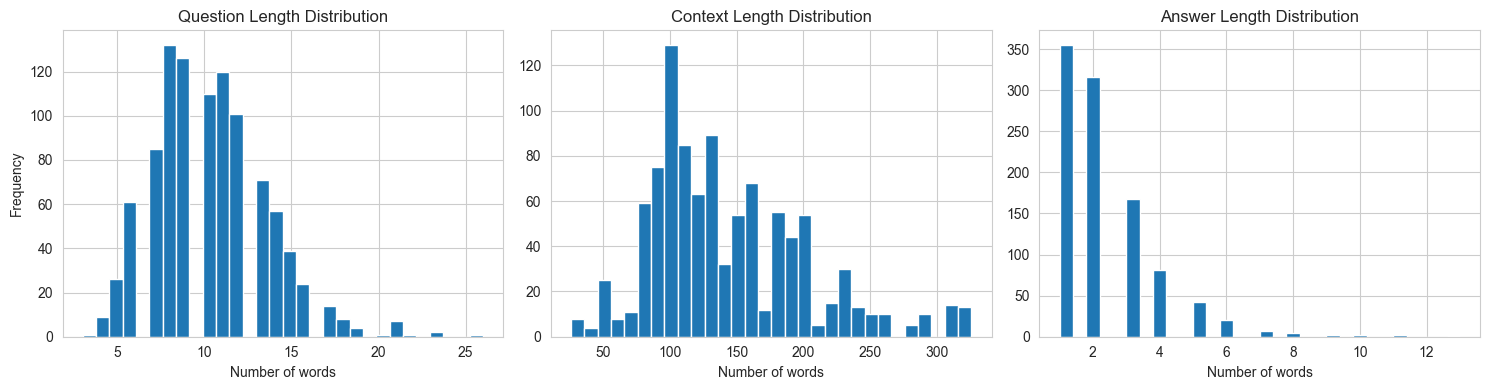

In [5]:
# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

train_stats["Question Length"].hist(bins=30, ax=axes[0])
axes[0].set_title("Question Length Distribution")
axes[0].set_xlabel("Number of words")
axes[0].set_ylabel("Frequency")

train_stats["Context Length"].hist(bins=30, ax=axes[1])
axes[1].set_title("Context Length Distribution")
axes[1].set_xlabel("Number of words")

train_stats["Answer Length"].hist(bins=30, ax=axes[2])
axes[2].set_title("Answer Length Distribution")
axes[2].set_xlabel("Number of words")

plt.tight_layout()
plt.show()


## 3. Data Preprocessing


In [6]:
# Load tokenizer
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

print(f"Loaded tokenizer: {model_name}")
print(f"Tokenizer class: {type(tokenizer).__name__}")
print(f"Vocabulary size: {len(tokenizer)}")


/Users/tanno/Library/Python/3.9/lib/python/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Loaded tokenizer: microsoft/deberta-v3-base
Tokenizer class: DebertaV2TokenizerFast
Vocabulary size: 128001


In [7]:
# Tokenize a sample to understand the process
sample = dataset["train"][0]
question = sample["question"]
context = sample["context"]

# Tokenize
encoded = tokenizer(
    question,
    context,
    max_length=384,
    truncation="only_second",
    return_offsets_mapping=True,
    padding="max_length"
)

print("Tokenized example:")
print(f"Input IDs shape: {len(encoded['input_ids'])}")
print(f"\nFirst 10 tokens:")
print(tokenizer.convert_ids_to_tokens(encoded['input_ids'][:10]))
print(f"\nDecoded (first 100 chars): {tokenizer.decode(encoded['input_ids'][:50])}")


Tokenized example:
Input IDs shape: 384

First 10 tokens:
['[CLS]', '▁To', '▁whom', '▁did', '▁the', '▁Virgin', '▁Mary', '▁allegedly', '▁appear', '▁in']

Decoded (first 100 chars): [CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?[SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main


In [8]:
# Prepare full datasets from local files (this may take a few minutes)
print("Preparing datasets for training from local JSON files...")
train_dataset, eval_dataset, raw_eval_dataset, tokenizer = load_and_prepare_data(
    train_file="../train-v1.1.json",
    validation_file="../dev-v1.1.json",
    model_name=model_name,
    max_length=384,
    doc_stride=128
)

print(f"\nPrepared {len(train_dataset)} training examples")
print(f"Prepared {len(eval_dataset)} validation examples")


Preparing datasets for training from local JSON files...
Loading: ../train-v1.1.json, ../dev-v1.1.json
Loaded 87599 train, 10570 val examples
Tokenizing data...


Train (num_proc=1):   0%|          | 0/87599 [00:00<?, ? examples/s]

Validation (num_proc=1):   0%|          | 0/10570 [00:00<?, ? examples/s]

Ready: 88316 train, 10756 val examples

Prepared 88316 training examples
Prepared 10756 validation examples


## 4. Model Training

For actual training, we recommend using the `scripts/train.py` script as it provides:
- Better logging and checkpointing
- Command-line configurability
- Easier distributed training

However, here's a simple training loop for demonstration:


In [9]:
# Load model
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
model.to(device)

print(f"Model loaded: {model_name}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")


Some weights of DebertaV2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: microsoft/deberta-v3-base
Number of parameters: 183,833,090


In [10]:
# Quick training setup (optional - use scripts/train.py for full training)
from transformers import TrainingArguments, Trainer, default_data_collator

# Reduced settings for experimentation
training_args = TrainingArguments(
    output_dir="../models/deberta-v3-base-squad-demo",
    eval_strategy="steps",  # Changed from evaluation_strategy
    eval_steps=500,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # Reduced
    weight_decay=0.01,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    fp16=device == "cuda",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset.select(range(1000)),  # Reduced 
    eval_dataset=eval_dataset.select(range(200)),      # Reduced
    tokenizer=tokenizer,
    data_collator=default_data_collator,
)


/var/folders/yc/csk0y45n6vlcqxrn2ywxv6700000gp/T/ipykernel_37634/3336326635.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
train_result = trainer.train()
trainer.save_model(training_args.output_dir)
tokenizer.save_pretrained(training_args.output_dir)

print(f"Training completed! Model saved to {training_args.output_dir}")


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.
/Users/tanno/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


Training completed! Model saved to ../models/deberta-v3-base-squad-demo


## 5. Loading a Trained Model & Evaluation


In [12]:
# Load the trained model
model_path = "../models/deberta-v3-base-squad-demo"
model = AutoModelForQuestionAnswering.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.to(device)

print(f"Model loaded from: {model_path}")


Model loaded from: ../models/deberta-v3-base-squad-demo


In [ ]:
eval_subset_size = 200  # Quick evaluation on 200 examples

eval_metrics, predictions = evaluate_model(
    model=model,
    tokenizer=tokenizer,
    eval_dataset=eval_dataset.select(range(eval_subset_size)), 
    raw_dataset=raw_eval_dataset.select(range(eval_subset_size)),  # Must match
    batch_size=64,
    device=device
)

print(f"\nEvaluation Results (on {eval_subset_size} examples):")
print(f"Exact Match: {eval_metrics['exact_match']:.2f}%")
print(f"F1 Score: {eval_metrics['f1']:.2f}%")


Generating predictions...


  0%|          | 0/4 [00:00<?, ?it/s]

Post-processing:   0%|          | 0/200 [00:00<?, ?it/s]


Evaluation Results (on 200 examples):
Exact Match: 71.00%
F1 Score: 74.49%

Note: For full evaluation on all 10756 examples, use scripts/train.py


## 6. Making Predictions


In [14]:
def predict_answer(question, context, model, tokenizer, device):
    """Make a prediction for a single question-context pair."""
    inputs = tokenizer(
        question,
        context,
        return_tensors="pt",
        max_length=384,
        truncation="only_second",
        padding="max_length"
    )
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    start_idx = torch.argmax(outputs.start_logits[0]).item()
    end_idx = torch.argmax(outputs.end_logits[0]).item()
    
    if end_idx >= start_idx:
        answer_tokens = inputs["input_ids"][0][start_idx:end_idx + 1]
        answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
    else:
        answer = ""
    
    return answer


In [15]:
answer = predict_answer(question, context, model, tokenizer, device)
print(f"Question: {question}")
print(f"Answer: {answer}")


Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer: Saint Bernadette Soubirous


In [16]:
# Test on multiple examples from validation set
# num_examples = 5
# for i in range(num_examples):
#     example = raw_eval_dataset[i]
#     question = example["question"]
#     context = example["context"]
#     true_answer = example["answers"]["text"][0] if len(example["answers"]["text"]) > 0 else ""
#     
#     predicted_answer = predict_answer(question, context, model, tokenizer, device)
#     
#     print(f"\nExample {i+1}:")
#     print(f"Question: {question}")
#     print(f"True Answer: {true_answer}")
#     print(f"Predicted Answer: {predicted_answer}")
#     print("-" * 80)


## 7. Error Analysis


In [17]:
# Analyze prediction errors
# from src.evaluation import compute_exact_match, compute_f1

# def analyze_errors(predictions, raw_dataset, num_examples=10):
#     """Analyze examples where the model made mistakes."""
#     errors = []
#     
#     for example in raw_dataset:
#         example_id = example["id"]
#         if example_id not in predictions:
#             continue
#         
#         pred = predictions[example_id]
#         true_answers = example["answers"]["text"]
#         
#         if len(true_answers) == 0:
#             continue
#         
#         # Check if prediction is wrong
#         em = max(compute_exact_match(pred, ans) for ans in true_answers)
#         
#         if em == 0:  # Wrong prediction
#             errors.append({
#                 'question': example['question'],
#                 'context': example['context'][:200] + '...',
#                 'true_answer': true_answers[0],
#                 'predicted': pred
#             })
#         
#         if len(errors) >= num_examples:
#             break
#     
#     return errors

# error_examples = analyze_errors(predictions, raw_eval_dataset, num_examples=5)
# for i, err in enumerate(error_examples):
#     print(f"\nError Example {i+1}:")
#     print(f"Question: {err['question']}")
#     print(f"Context: {err['context']}")
#     print(f"True Answer: {err['true_answer']}")
#     print(f"Predicted: {err['predicted']}")
#     print("-" * 80)


## 8. Next Steps

1. **Full Training**: Use `scripts/train.py` for complete training
2. **Ensemble Methods**: Train multiple models and ensemble their predictions
3. **Additional Datasets**: Use NewsQA, SQuAD 2.0, Natural Questions (as local files)
4. **Hyperparameter Tuning**: Experiment with learning rates, batch sizes, etc.
5. **Model Comparison**: Try different architectures (BERT, RoBERTa, ELECTRA)

### Training Command Example (Using Local Files)
```bash
python scripts/train.py \
    --train_file train-v1.1.json \
    --validation_file dev-v1.1.json \
    --model_name microsoft/deberta-v3-base \
    --output_dir ./models/deberta-v3-base-squad \
    --num_train_epochs 3 \
    --per_device_train_batch_size 8 \
    --learning_rate 3e-5 \
    --fp16
```
